In [202]:
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
import numpy as np
import pandas as pd
from scipy import stats, sparse
import bottleneck
from scipy.stats import mannwhitneyu
import h5py
import h5py
import logging
import numpy as np
import pandas as pd
from hicmatrix import HiCMatrix as hm
from hicmatrix.lib import MatrixFileHandler
from scipy.sparse import csr_matrix, dia_matrix, triu, tril, coo_matrix
import scipy.stats as stats
import os.path
import gc
import os

In [86]:
process_type='inter'

species='mouse'
SRP_name='aggregates'
resolution='10kbp_raw'

In [97]:
with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/1kbp_raw/max/contact_top1/hic_gene_{process_type}_none_by_allbins_top1.h5', 'r') as hf:
    #my_data = hf['matrix'][:]
    gene_list = hf['gene_list'][:]

    bins_bed = hf['bins_bed'][:]

group cell_type  rank      gene  recurrence     auroc  \
0         GABAergic     Lamp5     1  Cacna2d1           7  0.918146   
5000  Glutamatergic   L2/3 IT     1   Rasgrf2           7  0.874715   

      fold_change  fold_change_detection  expression  precision   recall  \
0       10.042314               2.918454  679.620180   0.421814  0.92017   
5000     8.544493               3.443147  250.674531   0.475482  0.82578   

      population_size  n_datasets  scSS  snSS  scCv2  snCv2 snCv3M  scCv3  \
0         2037.857143           7  True  True   True   True   True   True   
5000     12214.285714           7  True  True   True   True   True   True   

     snCv3Z  
0      True  
5000   True

In [98]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'cluster']

number_of_genes_list = [100]
marker_level_list = ['cluster']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')

        #marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee//mouse_geneid_symbol.txt', sep='\t', names=['Ensembl_gene_identifier', 'Symbol'])
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin([x.decode() for x in gene_list])]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning:

Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.



In [99]:
cat_list_genes = marker_table.index.tolist()

In [100]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'cluster']

number_of_genes_list = [100]
marker_level_list = ['class']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')

        #marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee//mouse_geneid_symbol.txt', sep='\t', names=['Ensembl_gene_identifier', 'Symbol'])
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin([x.decode() for x in gene_list])]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

In [101]:
cat_list_genes.append(marker_table.index.tolist())

In [110]:
    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')
    

    
    



    #if species == 'human':

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/GRCh38-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #else:

    #        df_cre = pd.read_csv('/grid/gillis/data/lohia/ATAC_Risa/mm10-cCREs.bed', sep='\t', names=['chr', 'start', 'end', 't1', 't2', 't3'])

    #df_cre['start_bin'] = df_cre['start']/resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('int')
    #df_cre['start_bin'] = df_cre['start_bin']*resolution_human
    #df_cre['start_bin'] = df_cre['start_bin'].astype('str')
    #df_cre['start_bin'] = df_cre['chr'] + '_' + df_cre['start_bin']
    #df_cre_1kb_encode = df_cre.drop_duplicates(subset=['start_bin'])
    #df_cre['cre'] = 1
    #df_cre = df_cre.groupby(['start_bin'])['cre'].sum().reset_index()
    
    #cre_bins = bins_bed.merge(df_cre, left_on='pos', right_on='start_bin')['bin_id'].tolist()
    

                                                                

      
    chr_list = bins_bed.drop_duplicates(subset=['chr'])['chr'].tolist()
    chrom_index_list = {}
    for chrom in chr_list:
          st = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[0]
          en = bins_bed[bins_bed['chr'] == chrom]['bin_id'].tolist()[-1]
          chrom_index_list[chrom] = list(range(st, en+1))

    chrom_index_list_intra = {}
    for chrom in chr_list:
        index_list = []
        for chrom2 in chr_list:
            if chrom2 != chrom:
                index_list.extend(chrom_index_list[chrom2])
        
        chrom_index_list_intra[chrom] = index_list

    exp_file = hm.hiCMatrix(f'/grid/gillis/data/lohia/hi_c_data_processing/software/CoCoCoNet/networks/{species}_prioAggNet.h5')
    exp_genes_all = [x[3].decode() for x in exp_file.cut_intervals]
    chrom_vals = [x[0] for x in exp_file.cut_intervals]
    
    with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:
            tot_g = (list(hf.keys()))
    
    if resolution == '1kbp_raw':
        prec = 'float32'
    else:
        prec = 'float32'
    
    
        
    finite_list = []
    gene_list_list = []
    chrn_write_list_list = []
    my_data_thresh_list = []
    gene_depth_list = []
    
    marker_contacts_list_inter = []

    gene_list = []
        
    chrn_write_list = []
    
    for each_chrom in chr_list:
      
        
        if process_type == 'inter':


            with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                    
                                      if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)
                                            my_data[chrom_index_list[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)

        else:

            with h5py.File(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/hic_gene_gw_none_by_allbins_none.h5', 'r') as hf:

                               #for key in all_background_markers:
                               for key, m_chrom in zip(exp_genes_all, chrom_vals):
                                  if key in tot_g:
                                    if key in cat_list_genes:
                                        if m_chrom == each_chrom:
                                            gene_list.append(key)
                                            chrn_write_list.append(m_chrom)
                                            #which ever chrom the gene falls into, those bins should be nan
                                            my_data = hf[key][()]
                                            my_data = my_data.astype(prec)

                                            #gene_chrom = gene_bed[gene_bed['gene'] == key]['chr'].values[0]
                                            my_data[chrom_index_list_intra[each_chrom]] = np.nan
                                            gene_depth_list.append(bottleneck.nansum(my_data))
                                            marker_contacts_list_inter.append(my_data)
                                        
    my_data = np.array(marker_contacts_list_inter)
                                    

In [111]:
my_data_zcore = stats.zscore(my_data,axis=1, nan_policy='omit')  

In [126]:
pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')

group     cell_type  rank    gene  recurrence     auroc  fold_change  \
0      all     GABAergic     1    Gad1           7  0.941159   116.960472   
1      all     GABAergic     2    Gad2           7  0.928440   139.811415   
2      all     GABAergic     3   Erbb4           7  0.921449    81.717383   
3      all     GABAergic     4  Kcnip1           7  0.916919    32.252038   
4      all     GABAergic     5   Rbms3           7  0.902093    17.038869   
...    ...           ...   ...     ...         ...       ...          ...   
2995   all  Non-Neuronal   996     Rdx           2  0.545699     3.451569   
2996   all  Non-Neuronal   997  Cox4i2           2  0.544316    10.148337   
2997   all  Non-Neuronal   998   Ahnak           2  0.543616     9.461382   
2998   all  Non-Neuronal   999    Rcn3           2  0.543308     9.104208   
2999   all  Non-Neuronal  1000    Btg1           2  0.542415     3.853762   

      fold_change_detection   expression  precision    recall  \
0                  9.289078   820.463486   0.659089  0.894510   
1                 13.987046   659.151566   0.730005  0.865249   
2                  5.736415  2257.167753   0.514809  0.880164   
3                 10.796420   588.571993   0.687830  0.865456   
4                  3.607831   340.701798   0.442861  0.871912   
...                     ...          ...        ...       ...   
2995               0.975121   130.948069   0.065731  0.374215   
2996               6.289097     9.995411   0.212369  0.092097   
2997               2.001341    32.007215   0.108670  0.132105   
2998              14.388904     8.094364   0.456046  0.087680   
2999               0.939375    83.499889   0.064659  0.319867   

      population_size  n_datasets   scSS   snSS  scCv2  snCv2  snCv3M  scCv3  \
0        10207.000000           7   True   True   True   True    True   True   
1        10207.000000           7   True   True   True   True    True   True   
2        10207.000000           7   True   True   True   True    True   True   
3        10207.000000           7   True   True   True   True    True   True   
4        10207.000000           7   True   True   True   True    True   True   
...               ...         ...    ...    ...    ...    ...     ...    ...   
2995      8908.857143           7  False  False   True  False   False   True   
2996      8908.857143           7   True  False  False  False    True  False   
2997      8908.857143           7   True  False  False  False    True  False   
2998      8908.857143           7   True  False  False  False    True  False   
2999      8908.857143           7   True  False   True  False   False  False   

      snCv3Z  
0       True  
1       True  
2       True  
3       True  
4       True  
...      ...  
2995   False  
2996   False  
2997   False  
2998   False  
2999   False  

[3000 rows x 20 columns]

In [125]:
pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_cluster_markers.csv')

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning:

Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.



group       cell_type  rank           gene  recurrence     auroc  \
0      L2/3 IT       L2/3 IT_1     1  6530403H02Rik           5  0.842734   
1      L2/3 IT       L2/3 IT_1     2        Adamts2           5  0.752062   
2      L2/3 IT       L2/3 IT_1     3        Col23a1           5  0.702306   
3      L2/3 IT       L2/3 IT_1     4            Met           5  0.702247   
4      L2/3 IT       L2/3 IT_1     5            Ust           5  0.696202   
...        ...             ...   ...            ...         ...       ...   
85995      Vip  Vip Serpinf1_3   996        Gm13031           0  0.594600   
85996      Vip  Vip Serpinf1_3   997        Tmem41a           0  0.594572   
85997      Vip  Vip Serpinf1_3   998           Wwp1           0  0.594570   
85998      Vip  Vip Serpinf1_3   999         Osbpl7           0  0.594559   
85999      Vip  Vip Serpinf1_3  1000          Xrcc5           0  0.594531   

       fold_change  fold_change_detection  expression  precision    recall  \
0         5.410202               2.606655  255.840030   0.095304  0.830882   
1         7.557666               4.621909   99.357999   0.152135  0.582932   
2        12.460411               7.980352   61.676311   0.219897  0.446298   
3         9.147210               6.442665   53.928589   0.201546  0.445979   
4         6.217147               3.645296   59.489654   0.121974  0.479271   
...            ...                    ...         ...        ...       ...   
85995     1.808722               1.339642    0.000000   0.055076  0.226728   
85996     0.824817               0.705201    0.000000   0.018392  0.324274   
85997     0.923881               0.698012    0.000000   0.029692  0.610828   
85998     1.114155               1.857670   20.178161   0.026148  0.361312   
85999     1.308560               1.175172    0.000000   0.041882  0.359141   

       population_size  n_datasets   scSS   snSS  scCv2  snCv2  snCv3M  scCv3  \
0           492.833333           6    NaN  False   True   True    True   True   
1           492.833333           6    NaN  False   True   True    True   True   
2           492.833333           6    NaN  False   True   True    True   True   
3           492.833333           6    NaN  False   True   True    True   True   
4           492.833333           6    NaN  False   True   True    True   True   
...                ...         ...    ...    ...    ...    ...     ...    ...   
85995        45.000000           7  False  False  False  False   False  False   
85996        45.000000           7  False  False  False  False   False  False   
85997        45.000000           7  False  False  False  False   False  False   
85998        45.000000           7  False  False  False  False   False  False   
85999        45.000000           7  False  False  False  False   False  False   

      snCv3Z  
0       True  
1       True  
2       True  
3       True  
4       True  
...      ...  
85995  False  
85996  False  
85997  False  
85998  False  
85999  False  

[86000 rows x 20 columns]

In [314]:
number_of_genes_list = [10, 50, 100, 150, 200, 250, 500, 1000]
marker_level_list = ['class', 'subclass', 'cluster']

number_of_genes_list = [100]
marker_level_list = ['cluster']

for number_of_genes in number_of_genes_list:
    for marker_level in marker_level_list:


        marker_list = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_{marker_level}_markers.csv')
        marker_list_temp = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_class_markers.csv')
        marker_list_temp['group'] = marker_list_temp['cell_type']
        marker_list = pd.concat([marker_list, marker_list_temp])

        #marker_list['gene'] = marker_list['gene'].str.upper()
        df_ensg_name = pd.read_csv('/grid/gillis/data/lohia/hi_c_data_processing/genomes_jlee//mouse_geneid_symbol.txt', sep='\t', names=['Ensembl_gene_identifier', 'Symbol'])
        marker_list = marker_list.merge(df_ensg_name.drop_duplicates(), right_on='Symbol', left_on='gene') 
        marker_list = marker_list[marker_list['Ensembl_gene_identifier'].isin(gene_list)]
        
        all_cell_types = marker_list.drop_duplicates(['cell_type'])['cell_type'].tolist()
        df2_list = []



        for group2 in all_cell_types:
            df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes))
            #marker_list['cell_type'] =   marker_list['cell_type'].sample(frac = 1).values
            #df2_list.append(marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).tail(number_of_genes))
            #print ((marker_list[marker_list['cell_type']==group2].sort_values(by=['rank']).head(number_of_genes)).shape[0])
        marker_list=pd.concat(df2_list)
        #marker_list = marker_list[marker_list['rank'] <= number_of_genes] 
        
        #marker_list = marker_list[marker_list['auroc'] >= 0.85] 
        #marker_list = marker_list[marker_list.group.isin(['Sst'])]

        #marker_list = marker_list[marker_list.cell_type.isin(['Pvalb_1', 'Pvalb_2'])]
        #marker_list = marker_list.drop_duplicates(subset=['gene'], keep=False)
                
        #m_number_of_genes = number_of_genes +20
        #marker_list = marker_list[marker_list['rank'] < m_number_of_genes]
        #marker_list = marker_list.sort_values(by=['rank'])
        #print (marker_list)
        marker_list = marker_list.sort_values(by='rank').drop_duplicates(subset=['Ensembl_gene_identifier'])
        
        marker_table = marker_list.pivot_table(index='Ensembl_gene_identifier', columns='cell_type', values='rank', aggfunc='sum')

        marker_table.fillna(0, inplace=True)

        marker_table[marker_table != 0] = 1

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning:

Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.



In [342]:
if marker_level == 'cluster':

    marker_list_t = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_subclass_markers.csv')

    marker_list_t = marker_list_t.drop_duplicates(subset='cell_type')

    marker_list_t.rename(columns = {'group':'classt'}, inplace = True)
    marker_list_t.rename(columns = {'cell_type':'group'}, inplace = True)


    marker_list = marker_list[['Ensembl_gene_identifier', 'group', 'cell_type']].merge(marker_list_t[['classt', 'group']], how='left')
    
if marker_level == 'subclass':
    marker_list.rename(columns = {'group':'classt'}, inplace = True)
    marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
    marker_list['cell_type'] = marker_list['group'].tolist()

    
if marker_level == 'class':
    #marker_list.rename(columns = {'group':'classt'}, inplace = True)
    #marker_list.rename(columns = {'cell_type':'group'}, inplace = True)
    marker_list['group'] = marker_list['cell_type'].tolist()
    marker_list['classt'] = marker_list['cell_type'].tolist()
    #marker_list['cell_type'] = marker_list['Ensembl_gene_identifier'].tolist()

In [343]:
marker_list['classt'] = [y if y=='Non-Neuronal' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
marker_list['classt'] = ['Glutamatergic' if y=='L4/5 IT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
marker_list['classt'] = ['Glutamatergic' if y=='L5 PT' else x for x,y in zip(marker_list['classt'], marker_list['group'])] 
#market_list = marker_list.dropna(subset=['classt'])

In [344]:
market_list['classt'].fillna('Glutamatergic')

0       Glutamatergic
1           GABAergic
2           GABAergic
3           GABAergic
4           GABAergic
            ...      
2540    Glutamatergic
2541    Glutamatergic
2542    Glutamatergic
2543        GABAergic
2544        GABAergic
Name: classt, Length: 2329, dtype: object

In [345]:
market_list

Ensembl_gene_identifier    group       cell_type         classt
0         ENSMUSG00000098097  L2/3 IT       L2/3 IT_1  Glutamatergic
1         ENSMUSG00000035273      Sst        Sst Hpse      GABAergic
2         ENSMUSG00000016194      Vip      Vip Chat_2      GABAergic
3         ENSMUSG00000033278      Vip  Vip Serpinf1_3      GABAergic
4         ENSMUSG00000092094    Lamp5   Lamp5 Egln3_2      GABAergic
...                      ...      ...             ...            ...
2540      ENSMUSG00000041889      L6b    L6b Shisa6_1  Glutamatergic
2541      ENSMUSG00000028701  L5/6 NP       L5/6 NP_3  Glutamatergic
2542      ENSMUSG00000097626      L6b        L6b Ror1  Glutamatergic
2543      ENSMUSG00000022479      Vip  Vip Serpinf1_2      GABAergic
2544      ENSMUSG00000014725    Lamp5      Lamp5 Lhx6      GABAergic

[2329 rows x 4 columns]

In [346]:
marker_list = marker_list.sample(frac=1)

marker_list = marker_list[['classt', 'group', 'cell_type', 'Ensembl_gene_identifier']]

In [347]:
marker_list.dropna()

classt    group        cell_type Ensembl_gene_identifier
598   Glutamatergic    L6 IT          L6 IT_2      ENSMUSG00000024084
2301      GABAergic     Sncg     Sncg Calb1_1      ENSMUSG00000029335
1712      GABAergic      Vip         Vip Gpc3      ENSMUSG00000033854
1826      GABAergic      Sst        Sst Calb2      ENSMUSG00000020723
1277  Glutamatergic    L5 IT          L5 IT_1      ENSMUSG00000034118
...             ...      ...              ...                     ...
549   Glutamatergic  L2/3 IT        L2/3 IT_3      ENSMUSG00000029135
1517      GABAergic      Vip   Vip Serpinf1_1      ENSMUSG00000027523
2267  Glutamatergic  L5/6 NP        L5/6 NP_3      ENSMUSG00000073154
765       GABAergic      Sst  Sst Pvalb Calb2      ENSMUSG00000036422
1004      GABAergic      Sst        Sst Calb2      ENSMUSG00000033083

[2508 rows x 4 columns]

In [348]:
df_gene_tp = pd.DataFrame(my_data_zcore ,  index=gene_list, columns = bins_bed['bin_id'].tolist())

df_gene_tp = df_gene_tp.loc[marker_list['Ensembl_gene_identifier'].tolist(), :]


#df_gene_tp = df_gene_tp.fillna(0)

In [349]:
df_gene_tp_all_info = df_gene_tp.merge(marker_list, left_on=df_gene_tp.index, right_on=marker_list['Ensembl_gene_identifier'])

df_gene_tp_all_info = df_gene_tp_all_info.set_index('key_0')

df_gene_tp_all_info = df_gene_tp_all_info.drop(columns=['Ensembl_gene_identifier'])

In [350]:
df_gene_tp_all_info_mean = df_gene_tp_all_info.groupby(['classt','group']).mean()

In [447]:
all_bins_mean = df_gene_tp_all_info_mean.mean(axis=0)

all_bins_std = df_gene_tp_all_info_mean.std(axis=0)

In [352]:
all_bins_std.max()

8.030865669250488

In [353]:
all_bins_mean.max()

179.46388244628906

In [326]:
%matplotlib inline
import seaborn as sns
import random
bin_random = random.sample(range(2875012 ), 1000)

In [327]:
%matplotlib inline
import seaborn as sns

In [335]:
df_gene_tp_all_info_mean

0         1         2         3         4       \
classt        group                                                            
GABAergic     Lamp5        -1.172990 -1.172990 -1.172990 -1.172990 -1.172990   
              Pvalb        -1.181961 -1.181961 -1.181961 -1.181961 -1.181961   
              Sncg         -1.213986 -1.213986 -1.213986 -1.213986 -1.213986   
              Sst          -1.185000 -1.185000 -1.185000 -1.185000 -1.185000   
              Vip          -1.209764 -1.209764 -1.209764 -1.209764 -1.209764   
Glutamatergic L2/3 IT      -1.275009 -1.275009 -1.275009 -1.275009 -1.275009   
              L5 IT        -1.266969 -1.266969 -1.266969 -1.266969 -1.266969   
              L5/6 NP      -1.252923 -1.252923 -1.252923 -1.252923 -1.252923   
              L6 CT        -1.215472 -1.215472 -1.215472 -1.215472 -1.215472   
              L6 IT        -1.280793 -1.280793 -1.280793 -1.280793 -1.280793   
              L6b          -1.272449 -1.272449 -1.272449 -1.272449 -1.272449   
Non-Neuronal  Non-Neuronal -1.163880 -1.163880 -1.163880 -1.163880 -1.163880   

                              5         6         7         8         9       \
classt        group                                                            
GABAergic     Lamp5        -1.172990 -1.172990 -1.172990 -1.172990 -1.172990   
              Pvalb        -1.181961 -1.181961 -1.181961 -1.181961 -1.181961   
              Sncg         -1.213986 -1.213986 -1.213986 -1.213986 -1.213986   
              Sst          -1.185000 -1.185000 -1.185000 -1.185000 -1.185000   
              Vip          -1.209764 -1.209764 -1.209764 -1.209764 -1.209764   
Glutamatergic L2/3 IT      -1.275009 -1.275009 -1.275009 -1.275009 -1.275009   
              L5 IT        -1.266969 -1.266969 -1.266969 -1.266969 -1.266969   
              L5/6 NP      -1.252923 -1.252923 -1.252923 -1.252923 -1.252923   
              L6 CT        -1.215472 -1.215472 -1.215472 -1.215472 -1.215472   
              L6 IT        -1.280793 -1.280793 -1.280793 -1.280793 -1.280793   
              L6b          -1.272449 -1.272449 -1.272449 -1.272449 -1.272449   
Non-Neuronal  Non-Neuronal -1.163880 -1.163880 -1.163880 -1.163880 -1.163880   

                            ...    246275    246276    246277    246278  \
classt        group         ...                                           
GABAergic     Lamp5         ... -1.166299 -1.166299 -1.166299 -1.166299   
              Pvalb         ... -1.184609 -1.184609 -1.184609 -1.184609   
              Sncg          ... -1.210567 -1.210567 -1.210567 -1.210567   
              Sst           ... -1.189407 -1.189407 -1.189407 -1.189407   
              Vip           ... -1.226551 -1.226551 -1.226551 -1.226551   
Glutamatergic L2/3 IT       ... -1.270079 -1.270079 -1.270079 -1.270079   
              L5 IT         ... -1.251822 -1.251822 -1.251822 -1.251822   
              L5/6 NP       ... -1.252710 -1.252710 -1.252710 -1.252710   
              L6 CT         ... -1.226891 -1.226891 -1.226891 -1.226891   
              L6 IT         ... -1.298327 -1.298327 -1.298327 -1.298327   
              L6b           ... -1.277407 -1.277407 -1.277407 -1.277407   
Non-Neuronal  Non-Neuronal  ... -1.201643 -1.201643 -1.201643 -1.201643   

                              246279    246280    246281    246282    246283  \
classt        group                                                            
GABAergic     Lamp5        -1.166299 -1.166299 -1.166299 -1.166299 -1.166299   
              Pvalb        -1.184609 -1.184609 -1.184609 -1.184609 -1.184609   
              Sncg         -1.210567 -1.210567 -1.210567 -1.210567 -1.210567   
              Sst          -1.189407 -1.189407 -1.189407 -1.189407 -1.189407   
              Vip          -1.226551 -1.226551 -1.226551 -1.226551 -1.226551   
Glutamatergic L2/3 IT      -1.270079 -1.270079 -1.270079 -1.270079 -1.270079   
              L5 IT        -1.251822 -1.251822 -1.251822 -1.251822 -1.251822   
              L5/

In [329]:
pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/notebooks/metamarkers/biccn_cluster_markers.csv').drop_duplicates('group')



/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning:

Columns (15,16) have mixed types.Specify dtype option on import or set low_memory=False.



group      cell_type  rank           gene  recurrence     auroc  \
0      L2/3 IT      L2/3 IT_1     1  6530403H02Rik           5  0.842734   
3000   L4/5 IT      L4/5 IT_1     1          Alcam           7  0.842656   
5000     L5 IT        L5 IT_1     1       Il1rapl2           7  0.920723   
9000     L5 PT        L5 PT_1     1     St6galnac5           6  0.941773   
13000  L5/6 NP     L5/6 NP CT     1          Dpp10           5  0.924541   
17000    L6 CT     L6 CT Cpa6     1           Cpa6           7  0.685098   
23000    L6 IT        L6 IT_1     1            Fst           7  0.725532   
25000      L6b     L6b Col6a1     1            Me3           7  0.907122   
30000    Lamp5  Lamp5 Egln3_1     1         Sorcs1           7  0.938339   
38000    Pvalb  Pvalb Calb1_1     1           Rbp4           7  0.877404   
48000     Sncg   Sncg Calb1_1     1           Ror1           5  0.775448   
54000      Sst    Sst C1ql3_1     1         Lrrc4c           7  0.953338   
73000      Vip      Vip C1ql1     1        Pcdh11x           5  0.752137   

       fold_change  fold_change_detection   expression  precision    recall  \
0         5.410202               2.606655   255.840030   0.095304  0.830882   
3000      6.321937               2.378600   254.830922   0.760045  0.824937   
5000      8.288039               2.312840   701.292947   0.747480  0.938474   
9000     37.591045              12.170523   337.055918   0.894194  0.909953   
13000     8.934843               2.898682   550.454533   0.094626  0.927983   
17000     6.224114               3.374362   110.292061   0.955362  0.485029   
23000    14.404632               9.884477    72.796219   0.784853  0.488906   
25000     5.078506               1.752720   424.216183   0.330808  0.955439   
30000     6.764600               2.395591  1071.083992   0.129519  0.967392   
38000     5.638379               2.817830   479.660788   0.069427  0.900055   
48000     7.160739               6.154906    96.960892   0.393519  0.655674   
54000     6.126558               1.555961  1844.678972   0.068419  0.992225   
73000     4.531132               3.148638   343.110004   0.256276  0.679460   

       population_size  n_datasets   scSS   snSS scCv2 snCv2  snCv3M  scCv3  \
0           492.833333           6    NaN  False  True  True    True   True   
3000       8417.000000           7   True   True  True  True    True   True   
5000       3981.428571           7   True   True  True  True    True   True   
9000        828.428571           7  False   True  True  True    True   True   
13000        87.714286           7  False  False  True  True    True   True   
17000      9134.000000           7   True   True  True  True    True   True   
23000       907.857143           7   True   True  True  True    True   True   
25000       246.142857           7   True   True  True  True    True   True   
30000        88.285714           7   True   True  True  True    True   True   
38000        64.000000           7   True   True  True  True    True   True   
48000        45.857143           7  False  False  True  True    True   True   
54000       102.285714           7   True   True  True  True    True   True   
73000       262.571429           7   True  False  True  True    True  False   

      snCv3Z  
0       True  
3000    True  
5000    True  
9000    True  
13000   True  
17000   True  
23000   True  
25000   True  
30000   True  
38000   True  
48000   True  
54000   True  
73000   True

In [45]:


    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')

In [ ]:
df_prior = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/totg_reg_prior_only_top1_inter.csv', sep='\t')
#del_al = int(df_prior.shape[0]*no_of_high_bins/100)
given_bins = df_prior.sort_values(by=['prior_val']).tail(86276)['bin_id'].tolist()
        

In [265]:
all_bins_std[all_bins_std >= 0.005]

0         0.043419
1         0.043419
2         0.043419
3         0.043419
4         0.043419
            ...   
246280    0.040990
246281    0.040990
246282    0.040990
246283    0.040990
246284    0.040990
Length: 246285, dtype: float32

In [411]:
from umap import UMAP
import plotly.express as px
from sklearn.preprocessing import StandardScaler



#features = df.loc[:, :2875001]
#features = df_gene_tp.loc[:, :]
#features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]
features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >=0.0].index.tolist()]

features_sc =  StandardScaler().fit_transform(features)


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features_sc)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/umap/umap_.py:2344: UserWarning:

n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1



In [457]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
proj_2d = pca.fit_transform(features_sc)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='0', ylabel='1'>

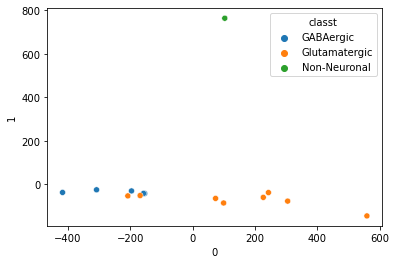

In [458]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='0', ylabel='1'>

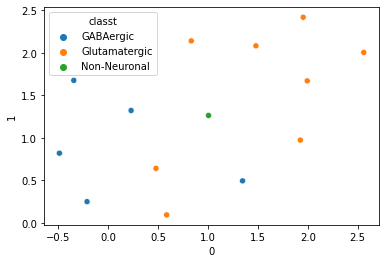

In [412]:
df_proj_2d= pd.DataFrame(proj_2d)

df_proj_2d['classt'] = df_gene_tp_all_info_mean.index.get_level_values('classt')
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'],
)

In [415]:
df_proj_2d['group'] = df_gene_tp_all_info_mean.index.get_level_values('group')

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



<AxesSubplot:xlabel='0', ylabel='1'>

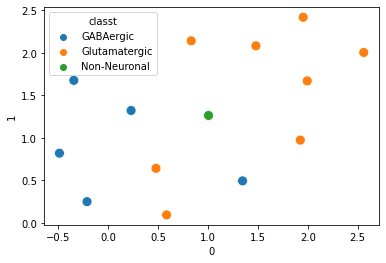

In [413]:
sns.scatterplot(
    df_proj_2d[0],df_proj_2d[1],
    hue=df_proj_2d['classt'], s=100
)

<ipython-input-456-7e0508507450>:10: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



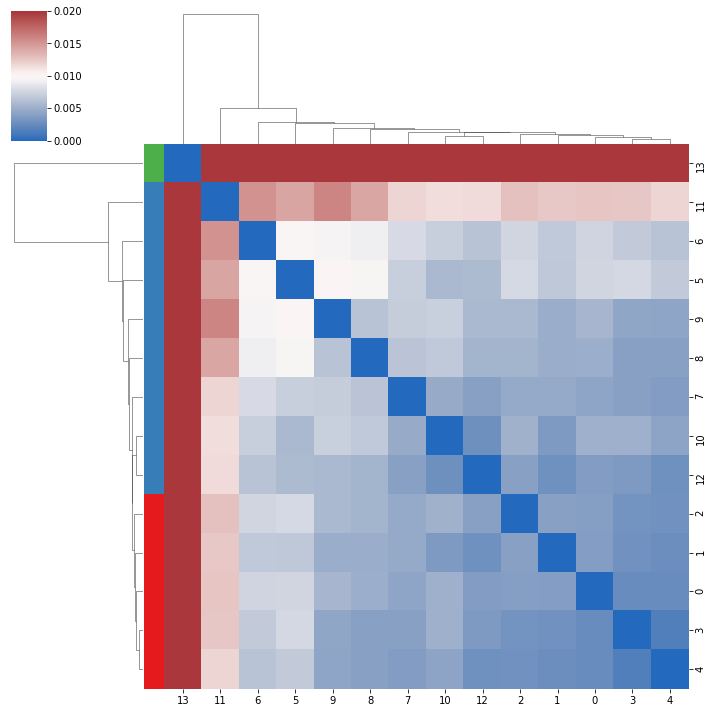

In [456]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)

features = df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_mean >0.5].index.tolist()]
R1 = np.round(np.corrcoef(features), 10)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
df_dist = 1-R1
df_dist[[np.arange(df_dist.shape[0])]*2] = 0
linkage = hc.linkage(sp.distance.squareform(df_dist), method='average')
sns.clustermap(df_dist, row_linkage=linkage, col_linkage=linkage, cmap="vlag", row_colors=row_colors, vmax=0.02)


In [443]:
all_bins_std[all_bins_mean >0.3]

304       0.116471
449       0.051725
471       0.056186
476       0.040462
504       0.081554
            ...   
246262    0.094327
246263    0.121759
246264    0.059855
246266    0.084684
246267    0.322826
Length: 52532, dtype: float32

In [448]:
np.percentile(all_bins_mean, 95)

0.6597537398338317

In [416]:
df_proj_2d

0         1         classt         group
0  -0.490363  0.821454      GABAergic         Lamp5
1  -0.346157  1.677703      GABAergic         Pvalb
2   0.228032  1.323310      GABAergic          Sncg
3  -0.213519  0.251147      GABAergic           Sst
4   1.345359  0.495500      GABAergic           Vip
5   2.560550  2.005934  Glutamatergic       L2/3 IT
6   1.924627  0.975139  Glutamatergic       L4/5 IT
7   0.831186  2.142354  Glutamatergic         L5 IT
8   0.584240  0.095157  Glutamatergic         L5 PT
9   0.477390  0.642606  Glutamatergic       L5/6 NP
10  1.993863  1.671747  Glutamatergic         L6 CT
11  1.953021  2.420190  Glutamatergic         L6 IT
12  1.479449  2.083828  Glutamatergic           L6b
13  1.004428  1.264880   Non-Neuronal  Non-Neuronal

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



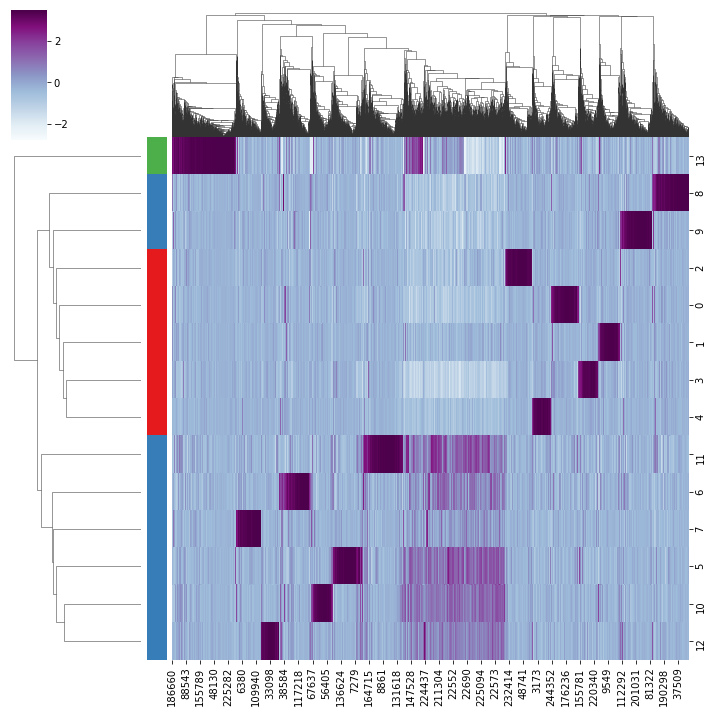

In [403]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >= 0.18].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=row_colors, z_score=1)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



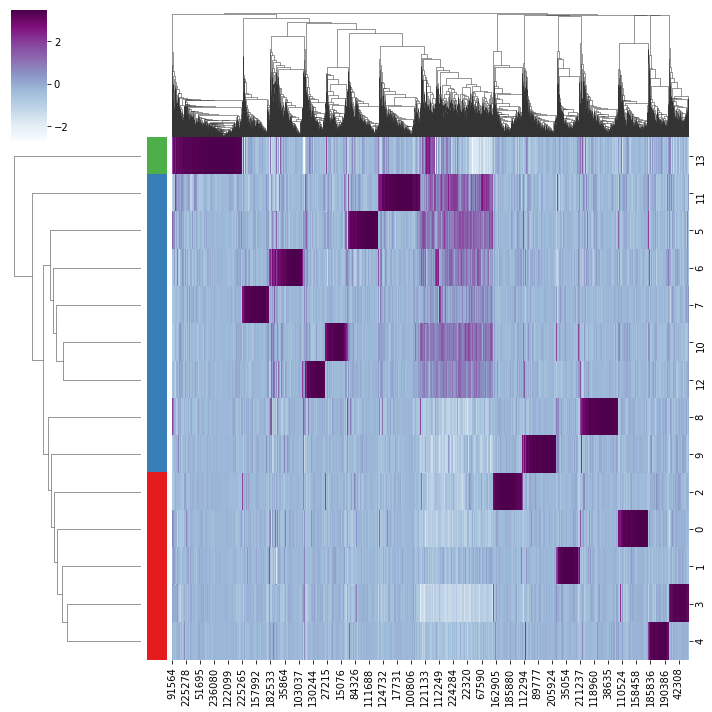

In [404]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >= 0.19].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=row_colors, z_score=1)


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/matrix.py:654: UserWarning:

Clustering large matrix with scipy. Installing `fastcluster` may give better performance.



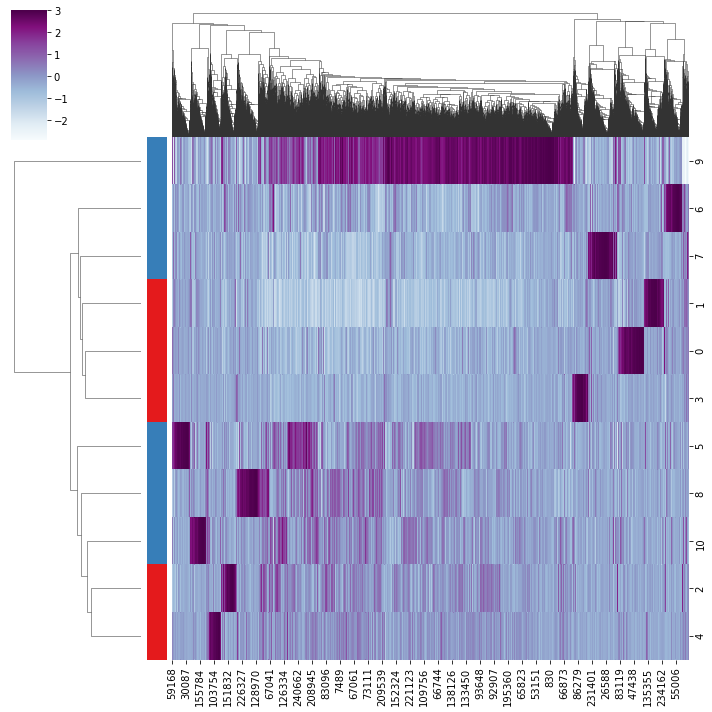

In [85]:
lut = dict(zip( df_gene_tp_all_info_mean.index.get_level_values('classt').drop_duplicates(), sns.color_palette("Set1", df_gene_tp_all_info_mean.index.get_level_values('classt').shape[0]).as_hex()[:]))


row_colors =df_gene_tp_all_info_mean.index.get_level_values('classt').map(lut)
sns.clustermap(df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >= 0.2].index.tolist()].reset_index(drop=True), cmap="BuPu", col_cluster=True, robust=False, row_colors=row_colors, z_score=1)


In [27]:
df_gene_tp_all_info_mean.loc[:, all_bins_std[all_bins_std >= 6].index.tolist()].reset_index(drop=True)

29414
0   174.477783
1   168.389084
2   182.006775
3   175.627823
4   177.750229
5   183.162354
6   184.160522
7   166.849304
8   182.848175
9   181.906143
10  186.417938

In [198]:
df_gene_tp_all_info_mean.max().max()

1.0

In [158]:


    input_path=f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/'
    bins_bed = pd.read_csv(f'{input_path}/all_bins.bed', names=['chr', 'start', 'end', 'bin_id'])
    bins_bed['bin_id'] = bins_bed.index
    #bins_bed['pos'] = bins_bed['chr'] + '_' + bins_bed['start'].astype('str')
    
    bins_bed.to_csv(f'{input_path}/all_bins_true.bed', index=False, header=False, sep='\t')

    os.system(f"~/.conda/envs/hicexplorer/bin/bedtools intersect -c -b /grid/gillis/data/lohia/hi_c_data_processing/data_human/aggregates/li2022/screen_v2/GRCh38-ccREs.bed -a /grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/all_bins_true.bed >  /grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed")
    
    bins_bed_cre = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_human/{SRP_name}/{resolution}/cre_intersect.bed', names=['chr', 'start', 'end', 'bin_id', 'cre'], sep='\t')

In [159]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = df_gene_tp.loc[:, bins_bed_cre[bins_bed_cre['cre'] >= 3]['bin_id'].tolist()]


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)

In [162]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'classt'}, color_discrete_sequence=sns.color_palette("Spectral", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]
)


fig_2d.show()

In [134]:
df_prior = pd.read_csv(f'/grid/gillis/data/lohia/hi_c_data_processing/data_{species}/{SRP_name}/{resolution}/max/contact_top1/totg_reg_prior_only_top1_inter.csv', sep='\t')
#del_al = int(df_prior.shape[0]*no_of_high_bins/100)
given_bins = df_prior.sort_values(by=['prior_val']).tail(86276)['bin_id'].tolist()
        

In [135]:
from umap import UMAP
import plotly.express as px




#features = df.loc[:, :2875001]
features = df_gene_tp.loc[:, given_bins]


umap_2d = UMAP(n_components=2, init='random', random_state=0)


proj_2d = umap_2d.fit_transform(features)


In [140]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.cell_type, labels={'color': 'cell_type'}
)


fig_2d.show()

In [43]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.classt, labels={'color': 'classt'}
)


fig_2d.show()

In [53]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'group'}
)


fig_2d.show()

In [121]:
sns.color_palette("Paired", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]

['#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928',
 '#a6cee3',
 '#1f78b4',
 '#b2df8a',
 '#33a02c',
 '#fb9a99',
 '#e31a1c',
 '#fdbf6f',
 '#ff7f00',
 '#cab2d6',
 '#6a3d9a',
 '#ffff99',
 '#b15928']

In [124]:
fig_2d = px.scatter(
    proj_2d, x=0, y=1,
    color=marker_list.group, labels={'color': 'group'}, color_discrete_sequence=sns.color_palette("Spectral", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]
)


fig_2d.show()



In [129]:
marker_list.group.head()

0    L6 CT
1    L6 CT
2    L6 CT
3    L6 CT
4    L6 CT
Name: group, dtype: object

In [127]:
fig_2d = px.scatter(
     x=df_proj_2d[0], y=df_proj_2d[1],
    color=df_proj_2d.group, labels={'color': 'group'}, color_discrete_sequence=sns.color_palette("Spectral", df_proj_2d.group.drop_duplicates().shape[0]).as_hex()[:]
)


fig_2d.show()


/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



ValueError: 'color' kwarg must be an color or sequence of color specs.  For a sequence of values to be color-mapped, use the 'c' argument instead.

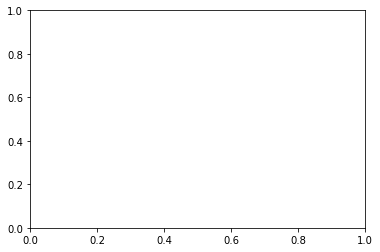

In [58]:
sns.scatterplot(proj_2d[:,0],proj_2d[:,1] , color=marker_list.group)

In [59]:
df_proj_2d= pd.DataFrame(proj_2d)

In [61]:
df_proj_2d['group'] = marker_list.group

In [62]:
df_proj_2d['cell_type'] = marker_list.cell_type

In [63]:
df_proj_2d['classt'] = marker_list.classt

In [72]:
df_proj_2d = df_proj_2d.sort_values(by=['classt', 'group', 'cell_type'])

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



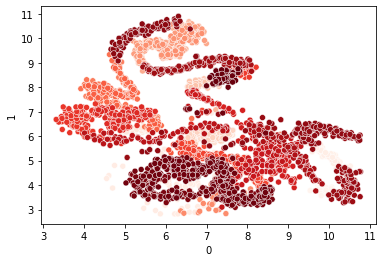

In [79]:
ax = sns.scatterplot(df_proj_2d[0], df_proj_2d[1] , hue=df_proj_2d.cell_type, legend=False, palette="Reds")

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



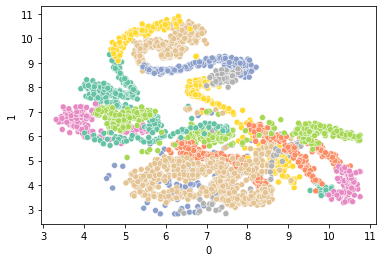

In [109]:
ax = sns.scatterplot(df_proj_2d[0], df_proj_2d[1] , hue=df_proj_2d.group, legend=False, palette=sns.color_palette("Set2", df_proj_2d.group.drop_duplicates().shape[0]))


In [111]:
color_palette("Set2", df_proj_2d.group.drop_duplicates().shape[0])

NameError: name 'color_palette' is not defined

/grid/gillis/home/lohia/.conda/envs/hicexplorer/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



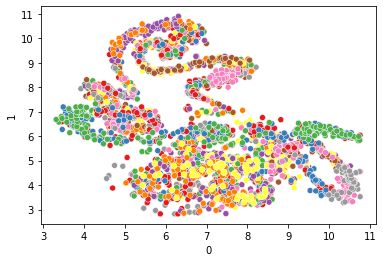

In [107]:
ax = sns.scatterplot(df_proj_2d[0], df_proj_2d[1] , hue=df_proj_2d.cell_type, legend=False, palette=sns.color_palette("Set1", df_proj_2d.cell_type.drop_duplicates().shape[0]))


In [98]:
df_proj_2d.group.drop_duplicates().shape[0]

24

In [83]:
sns.color_palette("hls", 20)

[(0.86, 0.3712, 0.33999999999999997),
 (0.86, 0.5272, 0.33999999999999997),
 (0.86, 0.6832, 0.33999999999999997),
 (0.86, 0.8392000000000002, 0.33999999999999997),
 (0.7247999999999999, 0.86, 0.33999999999999997),
 (0.5688000000000001, 0.86, 0.33999999999999997),
 (0.41279999999999994, 0.86, 0.33999999999999997),
 (0.33999999999999997, 0.86, 0.42320000000000013),
 (0.33999999999999997, 0.86, 0.5792000000000002),
 (0.33999999999999997, 0.86, 0.7352000000000001),
 (0.33999999999999997, 0.8287999999999999, 0.86),
 (0.33999999999999997, 0.6727999999999997, 0.86),
 (0.33999999999999997, 0.5167999999999995, 0.86),
 (0.33999999999999997, 0.36079999999999973, 0.86),
 (0.4752000000000003, 0.33999999999999997, 0.86),
 (0.6311999999999998, 0.33999999999999997, 0.86),
 (0.7871999999999999, 0.33999999999999997, 0.86),
 (0.86, 0.33999999999999997, 0.7767999999999993),
 (0.86, 0.33999999999999997, 0.6207999999999999),
 (0.86, 0.33999999999999997, 0.46479999999999977)]

In [84]:
sns.color_palette("Paired", 20)

[(0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0),
 (0.792156862745098, 0.6980392156862745, 0.8392156862745098),
 (0.41568627450980394, 0.23921568627450981, 0.6039215686274509),
 (1.0, 1.0, 0.6),
 (0.6941176470588235, 0.34901960784313724, 0.1568627450980392),
 (0.6509803921568628, 0.807843137254902, 0.8901960784313725),
 (0.12156862745098039, 0.47058823529411764, 0.7058823529411765),
 (0.6980392156862745, 0.8745098039215686, 0.5411764705882353),
 (0.2, 0.6274509803921569, 0.17254901960784313),
 (0.984313725490196, 0.6039215686274509, 0.6),
 (0.8901960784313725, 0.10196078431372549, 0.10980392156862745),
 (0.9921568627450981, 0.7490196078431373, 0.43529411764705883),
 (1.0, 0.4980392156862745, 0.0)]

In [118]:
sns.color_palette("Set2",20).as_hex()[:]

['#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3']

In [113]:
y = sns.color_palette("Set2",20)

In [116]:
y.as_hex()[:]

['#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3',
 '#a6d854',
 '#ffd92f',
 '#e5c494',
 '#b3b3b3',
 '#66c2a5',
 '#fc8d62',
 '#8da0cb',
 '#e78ac3']